In [0]:
# Fill in your name using the format below and student ID number
your_name = "TÜZES-BÖLÖNI, KINCSŐ"
student_id = "1553526"

In [0]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [0]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [25]:
# Uncomment the following line to run in Google Colab
# %tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy import stats

In [27]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi KINCSŐ, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# base_dir = '/content/drive/My Drive/assignment-3-tbkincso' # For Google Colab
base_dir = './'

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [0]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
oml.config.cache_directory = os.path.expanduser('/content/cache')
# oml.config.cache_directory = os.path.expanduser('/content/drive/My Drive/assignment-3-tbkincso/cache')

In [0]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [0]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [0]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

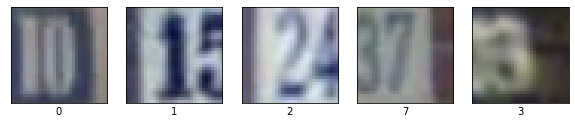

In [34]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
# print(X_train[0].shape)
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [0]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json 

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
  """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
  function following the Keras API. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  try:
    # if a json description is available, load config and then weights
    if os.path.isfile(os.path.join(base_dir, name+'.json')):
      json_file = open(os.path.join(base_dir, name+'.json'), 'r')
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json)
      model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
    else:
      model = load_model(os.path.join(base_dir, name+extension))
  except OSError:
    shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
    return False
  return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
  """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  path = os.path.join(base_dir, name+extension)
  model.save(path)
  size = os.path.getsize(path)
  # If model > 100MB, store the weights and architecture only.
  if size > 100*1024*1024:
    print("Model larger than 100MB, storing weights only.")
    model.save_weights(path)
    model_json = model.to_json()
    with open(os.path.join(base_dir, name+".json"), "w") as json_file:
        json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Training the model
Epoch 1/50
993/993 [==============================] - 3s 3ms/step - loss: 2.2323 - accuracy: 0.1870 - val_loss: 2.2155 - val_accuracy: 0.1910
Epoch 2/50
993/993 [==============================] - 3s 3ms/step - loss: 2.1855 - accuracy: 0.1911 - val_loss: 2.1413 - val_accuracy: 0.1961
Epoch 3/50
993/993 [==============================] - 3s 3ms/step - loss: 1.9479 - accuracy: 0.3297 - val_loss: 1.7274 - val_accuracy: 0.4216
Epoch 4/50
993/993 [==============================] - 3s 3ms/step - loss: 1.5259 - accuracy: 0.5053 - val_loss: 1.4616 - val_accuracy: 0.5316
Epoch 5/50
993/993 [==============================] - 3s 3ms/step - loss: 1.3153 - accuracy: 0.5881 - val_loss: 1.2710 - val_accuracy: 0.5965
Epoch 6/50
993/993 [==============================] - 3s 3ms/step - loss: 1.1909 - accuracy: 0.6335 - val_loss: 1.1448 - val_accuracy: 0.6515
Epoch 7/50
993/993 [==============================] - 3s 3ms/step - loss: 1.1183 - accuracy: 0.6589 - val_loss: 1.0870 - val_accu

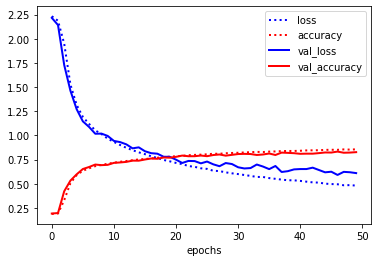

In [36]:
sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)
rmsprop = optimizers.RMSprop(lr=0.0001)
adam = optimizers.Adam(lr=0.0001)

def build_model_1_1(optimizer=sgd):
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(256, activation='relu', input_shape=(32*32*3, )))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='sigmoid'))
  
  model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

# 40 epochs: loss, acc, val_l, val_acc
# sgd: 2.225464  0.840378  2.194638      0.816265
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=64)
# rmsprop: 2.194522  0.822344  2.080309      0.807767
# run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
#                train=True, epochs=40, batch_size=64, optimizer=rmsprop) 
# adam: 2.169839  0.819731  1.927266      0.801347
# run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
#                train=True, epochs=40, batch_size=64, optimizer=adam)

answer_q_1_1 = """I used 3 pyramid shaped dense layers with relu activation,starting with 256 nodes,then halving this number.A sigmoid layer is used for classification.From SDG, Adam and RMSprop optimizers the SDG with 0.001 learning rate performed slightly better.The curves of the loss/accuracy start to flatten after 20 epochs,slowly decreasing/increasing further though,reaching 83% accuracy in 50 epochs.After 20 epochs very little overfitting is started, since the loss curves start to move away from each other."""
print("Answer is {} characters long".format(len(answer_q_1_1)))


### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [37]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

# Preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val
# preprocessed_split = rgb2gray(X_train) - 0.5, rgb2gray(X_val) - 0.5, y_train, y_val
print(preprocessed_split[0].shape)

(63544, 32, 32, 1)


Training the model
Epoch 1/50
993/993 [==============================] - 3s 3ms/step - loss: 2.2385 - accuracy: 0.1881 - val_loss: 2.2275 - val_accuracy: 0.1910
Epoch 2/50
993/993 [==============================] - 3s 3ms/step - loss: 2.2214 - accuracy: 0.1910 - val_loss: 2.2134 - val_accuracy: 0.1910
Epoch 3/50
993/993 [==============================] - 3s 3ms/step - loss: 2.1997 - accuracy: 0.1910 - val_loss: 2.1828 - val_accuracy: 0.1910
Epoch 4/50
993/993 [==============================] - 3s 3ms/step - loss: 2.1411 - accuracy: 0.2053 - val_loss: 2.0805 - val_accuracy: 0.2912
Epoch 5/50
993/993 [==============================] - 3s 3ms/step - loss: 1.8772 - accuracy: 0.3657 - val_loss: 1.6923 - val_accuracy: 0.4582
Epoch 6/50
993/993 [==============================] - 3s 3ms/step - loss: 1.5586 - accuracy: 0.4907 - val_loss: 1.4756 - val_accuracy: 0.5493
Epoch 7/50
993/993 [==============================] - 3s 3ms/step - loss: 1.3678 - accuracy: 0.5681 - val_loss: 1.3051 - val_accu

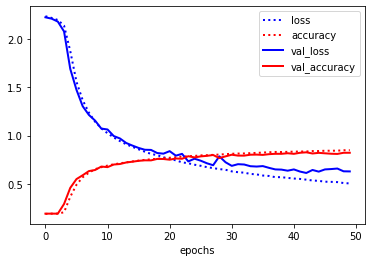

In [38]:
# x_t = preprocessed_split[0].flatten()
# print(x_t.shape, np.std(x_t), np.mean(x_t), stats.skew(x_t), "\n")
# plt.hist(x_t, color = 'blue', edgecolor = 'black', bins = int(180/5))

# Adjusted model
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32)))
  model.add(layers.Dense(256, activation='relu', input_shape=(32*32*3, )))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='sigmoid'))

  sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model


# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)

answer_q_1_2 = """Using the same model with greyscaled images ends in very similar results,82.7% accuracy,but it seems that the model starts (to a very small extent) overfitting later,after 30 epochs, suggesting that this approach is sligthly better. This seems reasonable since colors has no significance in these images.I tried to transform the input values to [-1, 1] instead of [0,1], that resulted in better 84% accuracy but in a more significant overfitting after 20 epochs, so I chose to use [0,1] input range."""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Training the model
Epoch 1/50
993/993 [==============================] - 3s 3ms/step - loss: 2.2944 - accuracy: 0.1955 - val_loss: 2.1867 - val_accuracy: 0.2308
Epoch 2/50
993/993 [==============================] - 3s 3ms/step - loss: 1.7716 - accuracy: 0.4259 - val_loss: 1.4123 - val_accuracy: 0.5919
Epoch 3/50
993/993 [==============================] - 3s 3ms/step - loss: 1.3952 - accuracy: 0.5831 - val_loss: 1.2454 - val_accuracy: 0.6483
Epoch 4/50
993/993 [==============================] - 3s 3ms/step - loss: 1.2537 - accuracy: 0.6352 - val_loss: 1.1794 - val_accuracy: 0.6653
Epoch 5/50
993/993 [==============================] - 3s 3ms/step - loss: 1.1609 - accuracy: 0.6710 - val_loss: 1.0887 - val_accuracy: 0.6935
Epoch 6/50
993/993 [==============================] - 3s 3ms/step - loss: 1.1018 - accuracy: 0.6859 - val_loss: 1.0461 - val_accuracy: 0.7123
Epoch 7/50
993/993 [==============================] - 3s 3ms/step - loss: 1.0635 - accuracy: 0.6982 - val_loss: 1.0327 - val_accu

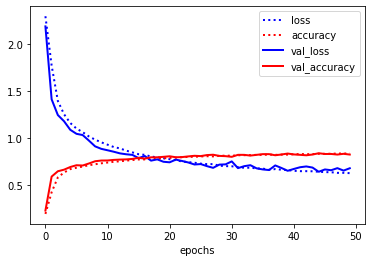

In [39]:
def build_model_1_3(learning_rate=0.005, l=0.0001, rate=0.05):
  # L1 reg. ~0.19 acc (5 epochs, bs 64)
  # L2 L1 ~0.19 acc (5 epochs, bs 64)
  # Dropout ~0.64 (10 epochs, bs 64)
  # L2 reg. ~0.69 (5 epochs, bs 64), ~0. 71 (10 epochs, bs 64)
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32)))
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=l), kernel_initializer='he_normal', input_shape=(32*32, )))
  model.add(layers.Dropout(rate=rate))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=l), kernel_initializer='he_normal'))
  model.add(layers.Dropout(rate=rate))
  model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=l), kernel_initializer='he_normal'))
  model.add(layers.Dropout(rate=rate))  
  model.add(layers.Dense(10, activation='sigmoid'))
  sgd = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

  model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

# clf = KerasClassifier(build_model_1_3)
# param_grid = {'epochs': [8],
#               'learning_rate': [0.0001, 0.005, 0.01],
#               'l': [0.0001, 0.001],
#               'rate': [0.05, 0.1, 0.2],
#               'verbose' : [1]}
# grid = GridSearchCV(clf, param_grid=param_grid, cv=2, return_train_score=True)
# grid.fit(preprocessed_split[0], preprocessed_split[2])
# res = pd.DataFrame(grid.cv_results_)
# res.pivot_table(index=["param_epochs", "param_l", "param_rate", "param_learning_rate"],
#                 values=["mean_train_score", "mean_test_score"])
# plt.show() 

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)

answer_q_1_3 = """I tried L2, L1, L2_L1,Dropout and BatchNormalization.L2 performed much better than the others,and it improved when combining with Dropout.Tuning the hyperparameters showed 0.005 SGD learning rate,0.05 dropout rate and 0.0001 regularization factor are the best combination,increasing the accuracy with 1%,and eliminating the overfitting in 50 epochs.The dropout is needed to prevent overfitting,but any bigger rate would lead to too much regularization,ending in better validation than training loss."""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Epoch 1/50
993/993 [==============================] - 9s 9ms/step - loss: 0.9448 - accuracy: 0.7094 - val_loss: 0.4894 - val_accuracy: 0.8452
Epoch 2/50
993/993 [==============================] - 8s 8ms/step - loss: 0.4014 - accuracy: 0.8797 - val_loss: 0.3331 - val_accuracy: 0.8965
Epoch 3/50
993/993 [==============================] - 8s 8ms/step - loss: 0.3294 - accuracy: 0.9032 - val_loss: 0.2564 - val_accuracy: 0.9242
Epoch 4/50
993/993 [==============================] - 8s 8ms/step - loss: 0.2940 - accuracy: 0.9152 - val_loss: 0.2443 - val_accuracy: 0.9264
Epoch 5/50
993/993 [==============================] - 8s 8ms/step - loss: 0.2754 - accuracy: 0.9196 - val_loss: 0.2531 - val_accuracy: 0.9250
Epoch 6/50
993/993 [==============================] - 8s 8ms/step - loss: 0.2577 - accuracy: 0.9271 - val_loss: 0.2062 - val_accuracy: 0.9392
Epoch 7/50
993/993 [==============================] - 8s 8ms/step - loss: 0.2396 - accuracy: 0.9317 - val_loss: 0.2167 - val_accu

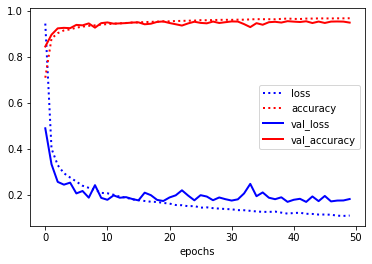

In [40]:
def build_model_2_1():
  # 91% accuracy but starts overfitting after 3 epochs also without padding (padding='valid')
  # model = models.Sequential()
  # model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 1)))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  # model.add(layers.Flatten())
  # model.add(layers.Dense(64, activation='relu'))
  # model.add(layers.Dense(10, activation='softmax'))

  # 92% acc, still starts to overfit after 3 epochs
  # model = models.Sequential()
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  # model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  # model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Flatten())
  # model.add(layers.Dense(128, activation='relu'))
  # model.add(layers.Dense(10, activation='softmax'))

  # with dropout 0.2 same results
  # increasing every dropout with 0.1 (starting from 0.2) => 91% acc, train acc 89%  -> model performs better on validation set -> too much regularization
  # with dropout 0.5 worse results => 90% acc, train acc 82% -> too much reg.
  # with batch normalization: 94% acc, no overfitting in 10 epochs, seems a bit much reg. because val. loss is slightly smaller
  # similar with 5x5 window
  # 95% acc if dropout is increased from 0.3 to 0.5 + batch normalization + 50 epochs (little overfitting after 40 epochs)

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))

  # model.summary()
  model.compile(optimizer='rmsprop', # better then sgd here
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model


run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)

answer_q_2_1 = """I used 3 blocks of 2 Conv2D layers.The first layer block has 32 filters,deeper layers increase it to 64,then 128 to preserve input information as resolution decreases.A dense layer with 128 nodes and a softmax layer is used for classification.I used zero-padding to build a deeper model,2x2 MaxPooling to increase translation invariance.A dropout layer is used after every MaxPooling and Dense layer with dropout rates increasing from 0.3 to 0.5,forcing deeper layers to regularize more than layers closer to the input.Combining it with BatchNormalization significantly decreases overfitting of the model and improves accuracy with 2%. A high accuracy (>90%) is already reached in 3-4 epochs,after that increasing very slowly up to 95% in 50 epochs.After 20 epochs it starts to overfit a little bit."""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

(32, 32, 1) (1, 32, 32, 1)


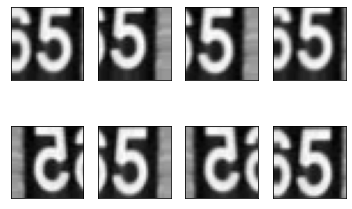

Training the model
Epoch 1/50
992/992 [==============================] - 15s 15ms/step - loss: 1.5062 - accuracy: 0.5145 - val_loss: 0.5280 - val_accuracy: 0.8318
Epoch 2/50
992/992 [==============================] - 15s 15ms/step - loss: 0.6692 - accuracy: 0.7881 - val_loss: 0.5624 - val_accuracy: 0.8191
Epoch 3/50
992/992 [==============================] - 15s 15ms/step - loss: 0.5346 - accuracy: 0.8363 - val_loss: 0.3656 - val_accuracy: 0.8846
Epoch 4/50
992/992 [==============================] - 15s 15ms/step - loss: 0.4735 - accuracy: 0.8573 - val_loss: 0.3068 - val_accuracy: 0.9053
Epoch 5/50
992/992 [==============================] - 15s 15ms/step - loss: 0.4360 - accuracy: 0.8681 - val_loss: 0.2645 - val_accuracy: 0.9197
Epoch 6/50
992/992 [==============================] - 15s 15ms/step - loss: 0.4147 - accuracy: 0.8755 - val_loss: 0.2805 - val_accuracy: 0.9151
Epoch 7/50
992/992 [==============================] - 15s 15ms/step - loss: 0.3915 - accuracy: 0.8828 - val_loss: 0.2

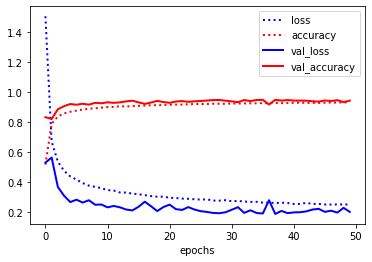

In [41]:
from tensorflow.keras.preprocessing import image

# 5 epochs:
# 10, 0.2, 0.1, 0.1, 0.1, True  => train 0.83% val 0.89%
# -, 0.1, 0.1, -, -, True => 86% 88%
# -, 0.2, 0.2, 0.1, 0.1, True => 83%, 89%
# 10, 0.3, -, 0.1, 0.1, True => 83%, 87%
# -, 0.3, - => 89% 91%
# -, 0.3, 0.1, - => 89% 89%
train_datagen = ImageDataGenerator(
    # rotation_range=5, # Rotate image
    width_shift_range=0.1, # Shift image left-right
    height_shift_range=0.1, # Shift image up-down
    # shear_range=0.1, # Shear (slant) the image 
    # zoom_range=0.1, # Zoom in
    horizontal_flip=True, # Horizontally flip the image
    fill_mode='nearest')

# Plot some augmented images
x = preprocessed_split[0][1].reshape((1,) + preprocessed_split[0][1].shape) 
print(preprocessed_split[0][1].shape, x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.subplot(241+i) 
  plt.xticks([]) 
  plt.yticks([])
  imgplot = plt.imshow(image.array_to_img(batch[0]), cmap='gray')
  i += 1
  if i == 8:
    break
plt.show()

it_train = train_datagen.flow(preprocessed_split[0], preprocessed_split[2], batch_size=64)
augmented_split = it_train, preprocessed_split[1], preprocessed_split[3]
steps = int(X_train.shape[0] / 64)

# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented data
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, generator=True, epochs=50, steps_per_epoch=steps, batch_size=None)

answer_q_2_2 = """Since the model 2.1 was barely overfitting and the size of training data is already quite large, data augmentation does not help to get a higher accuracy.In fact, applying rotation, zoom or sheer on these low resultion images destroyed too much information, ending in significant decrease of accuracy. I got the best result with small width shift, even smaller height shift,and horizontal flip, that was still not better than the results without data augmentation."""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

test loss, test acc: 0.20801407098770142 0.941887378692627
(1154,)


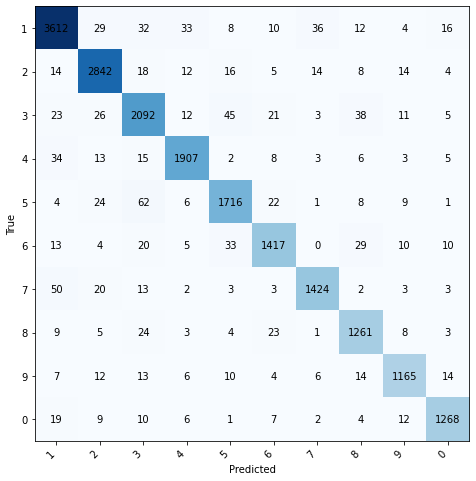

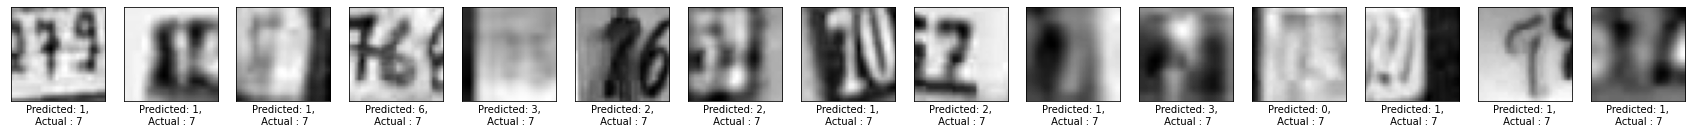

Answer is 499 characters long


In [42]:
from sklearn.metrics import confusion_matrix

target_classes = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5", 5: "6", 6: "7", 7: "8", 8: "9", 9: "0"}
preproc_X_test = rgb2gray(X_test)
model_2_2 = load_model_from_file(base_dir, 'model_2_2')

# Evaluate the model on the test data
test_loss_3_1, test_accuracy_3_1  = model_2_2.evaluate(preproc_X_test, y_test, verbose=0)
print('test loss, test acc:', test_loss_3_1, test_accuracy_3_1)

# Generate predictions on test data
y_pred = model_2_2.predict(preproc_X_test)
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

def plot_confusion_matrix():
  cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
  fig, ax = plt.subplots(1,figsize=(8,8))
  im = ax.imshow(cm, cmap=plt.cm.Blues)
  ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
  ax.set_xticklabels(list(target_classes.values()), rotation=45, ha="right")
  ax.set_yticklabels(list(target_classes.values()))
  ax.set_ylabel('True')
  ax.set_xlabel('Predicted')
  for i in range(100):
      ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="black")


def plot_misclassifications():
  fig, axes = plt.subplots(1, 15,  figsize=(30, 5))
  count = 0
  print(misclassified_samples.shape)
  for nr, i in enumerate(misclassified_samples):
      if (np.argmax(y_test[i])+1)%10 == 7:
        axes[count].imshow(preproc_X_test[i].reshape(32,32), cmap='gray')
        axes[count].set_xlabel("Predicted: %s,\n Actual : %s" % ((np.argmax(y_pred[i])+1)%10,(np.argmax(y_test[i])+1)%10)) # Label is index+1
        axes[count].set_xticks(()), axes[count].set_yticks(())
        count+=1
      if count == 15:
        break
  plt.show();


plot_confusion_matrix()
plot_misclassifications()

answer_q_3_1 = """Common misclassifications are between 3 and 5,but 4 is also often classified as 1 and 6 as 8.Very common mistake is to classify 7 as 1,therefore I visualized the first 10 misclassifications of class 7.We can see that errors are probably often related to noisiness or poor contrasts of the image. Sometimes the number is sligthly rotated that makes it more similar to 1,another time multiple numbers are appearing on one image and horizontal shifts move the wrong number into the center of the image."""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


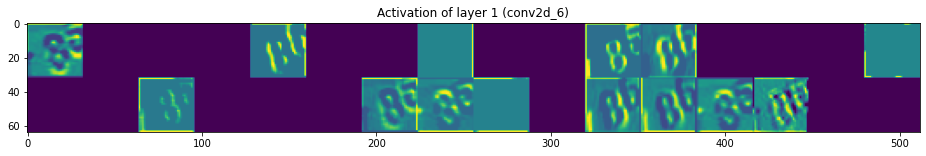

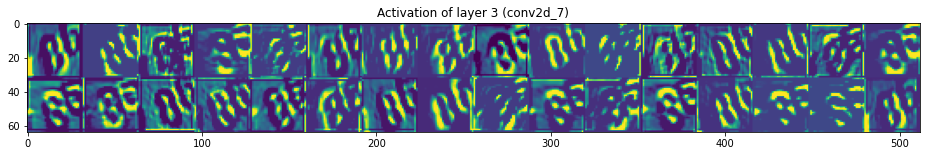

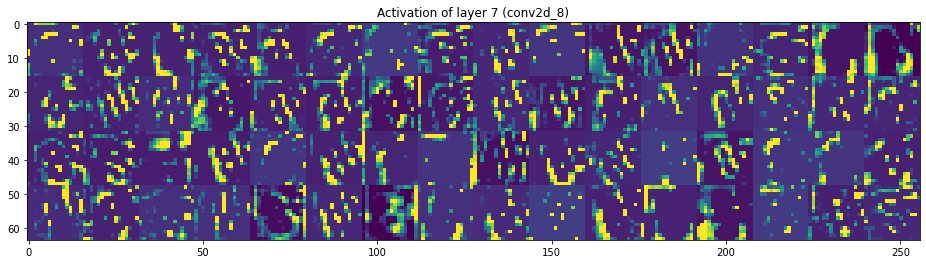

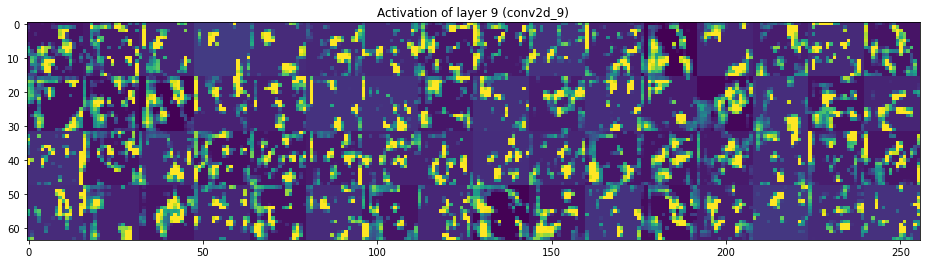

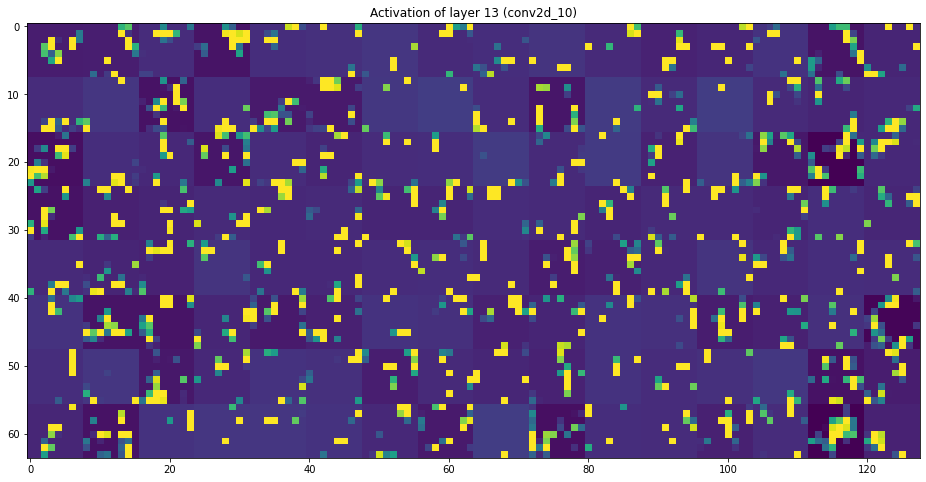

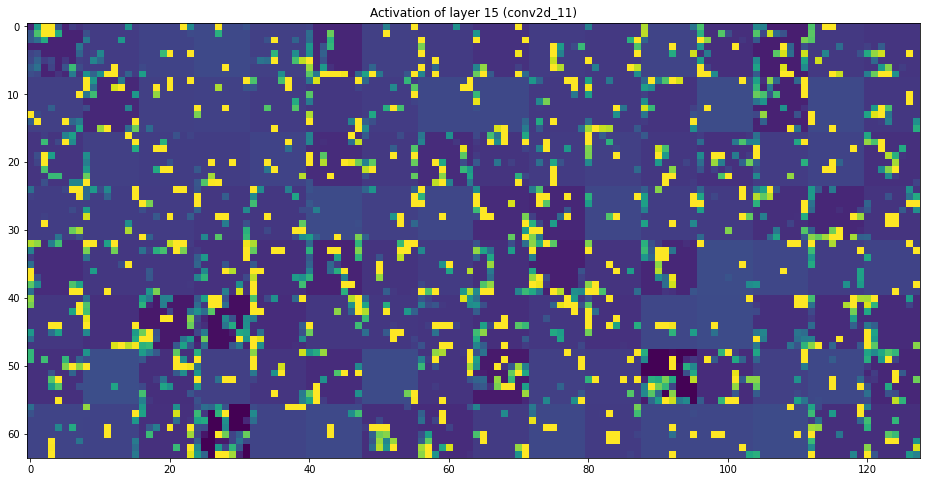

Answer is 419 characters long


In [43]:
model_2_2 = load_model_from_file(base_dir, 'model_2_2')
model_2_2.summary()

img_tensor = preproc_X_test[0]
img_tensor = np.expand_dims(img_tensor, axis=0) 

# Extracts the outputs of the top 15 layers (since we are interested in convolutional layers, and the last conv layer is layer 15):
layer_outputs = [layer.output for layer in model_2_2.layers[:15]]
# To extract the activations, we create a new model that outputs the trained layers. We input a test image for prediction and then read the relevant outputs
activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
  
layer_names = []
for layer in model_2_2.layers[:15]:
    layer_names.append(layer.name)

def plot_activations():
  layer_indices = [0, 2, 6, 8, 12, 14]
  
  for layer_index in layer_indices:
    images_per_row = 16
    start = layer_index
    end = layer_index+1
    # Display feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
      n_features = layer_activation.shape[-1] # number of features in the feature map
      size = layer_activation.shape[1] # shape (1, size, size, n_features)

      # Tile the activation channels in this matrix
      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      # Tile each filter into this big horizontal grid
      for col in range(n_cols):
        for row in range(images_per_row):
          channel_image = layer_activation[0, :, :, col * images_per_row + row]
          # Post-process the feature to make it visually palatable
          channel_image -= channel_image.mean()
          channel_image /= channel_image.std()
          channel_image *= 64
          channel_image += 128
          channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
      plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

      plt.show()

plot_activations()

answer_q_3_2 = """The first layer seems to concentrate mainly on diagonal edges, however it contains many empty filter activations, maybe because those inputs are too noisy, or not contrasted enough. The second layer seems to apply other edge detectors as well, catching the shape of number 8 quite well.Further layers are becoming more and more abstract, but on the next two layers, specific patterns of number 8 are still recognisable."""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


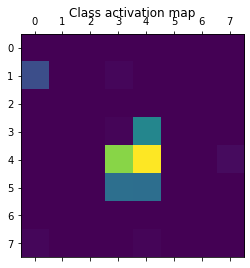

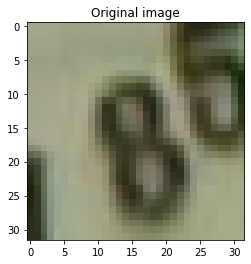

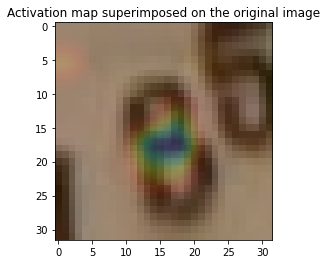

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import cv2

# https://github.com/tensorflow/tensorflow/issues/34235
tensorflow.compat.v1.disable_eager_execution()

K.clear_session()

model_2_2 = load_model_from_file(base_dir, 'model_2_2')

def plot_activation_map():
  img_tensor = preproc_X_test[0]
  img_tensor = np.expand_dims(img_tensor, axis=0) 

  # the "8" entry in the prediction vector
  eight_output = model_2_2.output[:, 7] 
  last_conv_layer = model_2_2.layers[15]
  # This is the gradient of the "8" class with regard to the output feature map of layer 15
  grads = K.gradients(eight_output, last_conv_layer.output)[0]
  # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us to access the values of the quantities we just defined:
  # `pooled_grads` and the output feature map of layer 15, given a sample image
  iterate = K.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])

  # These are the values of these two quantities, as Numpy arrays, given our sample image of number 8
  pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

  # We multiply each channel in the feature map array by "how important this channel is" with regard to the "8" class
  for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # Sanity test: do we get the right prediction?
  # preds = model_2_2.predict(img_tensor)
  # np.set_printoptions(precision=3)
  # print('Predicted:', preds) # [0.0007 0.0007 0.008 0.0001 0.0009 0.01 0.0002 0.9 0.008 0.001]

  # The channel-wise mean of the resulting feature map is our heatmap of class activation
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)
  plt.title('Class activation map')
  plt.show()

  return heatmap

def plot_3_3():
  heatmap = plot_activation_map()
  img = X_test[0]

  im1 = plt.imshow(img, interpolation='nearest')
  plt.title('Original image')
  plt.show()
  
  # resize the heatmap to have the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  # convert the heatmap to RGB
  heatmap = np.uint8(255 * heatmap)
  # apply Jet colormap on the heatmap to a have more visible color scale
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  im1 = plt.imshow(img, interpolation='nearest')
  im2 = plt.imshow(heatmap, alpha=.2, interpolation='bilinear')
  plt.title('Activation map superimposed on the original image')
  plt.show()

plot_3_3()


## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

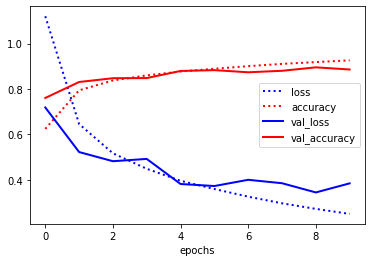

In [49]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

def build_model_4_1():
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  conv_base.summary()

  conv_base.trainable = True
  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))
  model.summary()

# RMSprop(lr=0.001), optimizers.Adam(lr=0.0001)
  model.compile(optimizer=optimizers.RMSprop(lr=0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
              
  return model
  
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=64)

# So we need to unfreeze the last few layers
answer_q_4_1 = """I added a dense layer with 256 nodes to the convolutional base, a dropout with 0.5 rate and RMSprop optimizer with learning rate of 0.0001. However, we have a large training set, it is probably too different from the one the vgg16 was trained on, because it only reaches an accuracy around 60%. Unfreezing the last two convolutional layers helps a lot, the accuracy increases to 89%, but after 6 epochs it seems that a little overfitting is started."""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [50]:
import pickle
import gzip
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model_4_1 = load_model_from_file(base_dir, 'model_4_1')
  model_4_1.summary()
  conv_base = model_4_1.get_layer(name='vgg16')
  
  store_embedding(conv_base.predict(X_train), 'X_train')
  store_embedding(conv_base.predict(X_test), 'X_test')

  # batch_size = 20
  # datagen = ImageDataGenerator()
  # generator = datagen.flow(X_train, batch_size=batch_size)
  # features = np.zeros(shape=(len(X_train), 1, 1, 512))
  # i = 0
  # for inputs_batch in generator:
  #   features_batch = conv_base.predict(inputs_batch)
  #   features[i * batch_size : (i + 1) * batch_size] = features_batch
  #   i += 1
  #   if i * batch_size >= len(X_train):
  #     break
  # store_embedding(features, 'train')

  # generator = datagen.flow(X_test, batch_size=batch_size)
  # features = np.zeros(shape=(len(X_test), 1, 1, 512))
  # i = 0
  # for inputs_batch in generator:
  #   features_batch = conv_base.predict(inputs_batch)
  #   features[i * batch_size : (i + 1) * batch_size] = features_batch
  #   i += 1
  #   if i * batch_size >= len(X_test):
  #     break
  # store_embedding(features, 'test')

def generate_pipeline():
  """ Returns an sklearn pipeline.
  """
  return Pipeline([("randomForest", RandomForestClassifier(max_depth=20))])
  # return Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100)))])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
  """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
  # print(pipeline)
  Xtrain = X_train.reshape(len(X_train), -1)
  ytrain = np.argmax(y_train, axis = 1)+1
  Xtest = X_test.reshape(len(X_test), -1)
  ytest = np.argmax(y_test, axis = 1)+1
  # print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

  pipeline.fit(X_train.reshape(len(X_train), -1), ytrain)
  # print("trained")
  return pipeline.score(X_test.reshape(len(X_test), -1), ytest)

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  if Path(base_dir+'/X_train_embedding.p').is_file() and Path(base_dir+'/X_test_embedding.p').is_file():
    print ("Embeddings already exist")
  else:
    print ("Embeddings do not exist, generate...")
    store_embeddings()
  X_train_embed = load_embedding('X_train')
  # print(X_train.shape, X_train_embed.shape)
  X_test_embed = load_embedding('X_test')
  
  pipe = generate_pipeline()
  return evaluate_pipeline(pipe, X_train_embed, y_train, X_test_embed, y_test)

acc = evaluation_4_2(X_train, y_train, X_test, y_test)
print("Accuracy:", acc)

answer_q_4_2 = """After generating the embeddings of the original images, I used the embedded training set to train a random forest classifier with a max depth of 20 and evaluated it on the embedded versions of the test images. The model reached a slightly higher accuracy then the previous model (model_4_1), increasing to 91.7%. However it does not beat the best model so far, the model_2_1."""
print("Answer is {} characters long".format(len(answer_q_4_2)))

Embeddings already exist
Accuracy: 0.9178668546681438
Answer is 375 characters long
